In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import re
import numpy as np

from fitter import Fitter, get_common_distributions, get_distributions
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.datasets import make_friedman3, make_s_curve
from sklearn.linear_model import BayesianRidge, ElasticNet
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor

# for Box-Cox Transformation
from scipy import stats

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from tqdm import tqdm
import math

from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame

# Data Collection

In [2]:
#Collect data from sensors (i.e., time-series data) installed in the manufacturing system 
data=pd.read_csv(r'3rd_paper_data\AI4I_Case_Study\raw_data\ai4i2020.csv')
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


# Feature Extraction

In [3]:
# Convert Rotational speed unit from rpm to rad/s
rad_s_array = (data["Rotational speed [rpm]"]/60) * (2 * math.pi)

# The product of torque and rotational speed (in rad/s) equals the power required for the process.
data["Required Power [W]"]=data["Torque [Nm]"]*rad_s_array

# Difference between process and air temperature
data["Heat Dissipation [K]"]=data["Process temperature [K]"]-data["Air temperature [K]"]

# The product of the tool wear and torque
data["Overstrain [minNm]"]=data["Torque [Nm]"]*data["Tool wear [min]"]

cols = data.columns.tolist()
cols = cols[-3:] + cols[:-3]
data=data[cols]
data.drop('UDI', inplace=True, axis=1) # Remove non-informative or redundant predictors from the model.
data.drop('Product ID', inplace=True, axis=1) # Remove non-informative or redundant predictors from the model.

#Removal of features that indicate the error type. The developed model will 
#predict the existence of a fault but also analyze the root cause.
data.drop('TWF', inplace=True, axis=1)
data.drop('HDF', inplace=True, axis=1)
data.drop('PWF', inplace=True, axis=1)
data.drop('OSF', inplace=True, axis=1)
data.drop('RNF', inplace=True, axis=1)
data.head()

,Required Power [W],Heat Dissipation [K],Overstrain [minNm],Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,6951.590560,10.5,0.0,M,298.1,308.6,1551,42.8,0,0
1,6826.722724,10.5,138.9,L,298.2,308.7,1408,46.3,3,0
2,7749.387543,10.4,247.0,L,298.1,308.5,1498,49.4,5,0
3,5927.504659,10.4,276.5,L,298.2,308.6,1433,39.5,7,0
4,5897.816608,10.5,360.0,L,298.2,308.7,1408,40.0,9,0


# Data pre-processing

### Ordinal Encoding
Encode ordinal categorical features (Product Quality). An ordinal variable is a categorical variable for which the possible values are ordered. Ordinal variables can be considered “in between” categorical and quantitative variables.

In [4]:
scale_mapper = {"L":0, "M":1, "H":2}
data["Type"] = data["Type"].replace(scale_mapper)

data.head()

,Required Power [W],Heat Dissipation [K],Overstrain [minNm],Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,6951.590560,10.5,0.0,1,298.1,308.6,1551,42.8,0,0
1,6826.722724,10.5,138.9,0,298.2,308.7,1408,46.3,3,0
2,7749.387543,10.4,247.0,0,298.1,308.5,1498,49.4,5,0
3,5927.504659,10.4,276.5,0,298.2,308.6,1433,39.5,7,0
4,5897.816608,10.5,360.0,0,298.2,308.7,1408,40.0,9,0


In [5]:
data.to_csv(r'3rd_paper_data\AI4I_Case_Study\raw_data\ai4i2020_feature_extraction.csv', index = False, header=True)

### k-fold Cross Validation 

In [6]:
X=data[['Required Power [W]','Heat Dissipation [K]','Overstrain [minNm]','Type','Air temperature [K]', 'Process temperature [K]','Torque [Nm]','Tool wear [min]']].to_numpy()
y=data[['Machine failure']].to_numpy()
kf = KFold(n_splits=10,shuffle=True)

print("K-fold Cross Validation")
i=0
for train_index, test_index in kf.split(X):
    i=i+1
    print("Iteration",i)
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    #print("X_train:", X_train, "X_test:", X_test)
    y_train, y_test = y[train_index], y[test_index]
    #print("y_train:", y_train, "y_test:", y_test)
    
    # convert array into dataframe
    X_train_dataset = pd.DataFrame(X_train)
    X_train_dataset.set_axis(['Required Power [W]','Heat Dissipation [K]','Overstrain [minNm]','Type','Air temperature [K]', 'Process temperature [K]','Torque [Nm]','Tool wear [min]'], axis=1, inplace=True)
    X_test_dataset = pd.DataFrame(X_test)
    X_test_dataset.set_axis(['Required Power [W]','Heat Dissipation [K]','Overstrain [minNm]','Type','Air temperature [K]', 'Process temperature [K]','Torque [Nm]','Tool wear [min]'], axis=1, inplace=True)
    y_train_dataset = pd.DataFrame(y_train)
    y_train_dataset.set_axis(['Machine failure'], axis=1, inplace=True)
    y_test_dataset = pd.DataFrame(y_test)
    y_test_dataset.set_axis(['Machine failure'], axis=1, inplace=True)

    
    # save the dataframe as a csv file
    X_train_dataset.to_csv(r'3rd_paper_data\AI4I_Case_Study\k-fold cross validation datasets\X_train_iter_'+str(i)+'.csv', index = False, header=True)
    X_test_dataset.to_csv(r'3rd_paper_data\AI4I_Case_Study\k-fold cross validation datasets\X_test_iter_'+str(i)+'.csv', index = False, header=True)
    y_train_dataset.to_csv(r'3rd_paper_data\AI4I_Case_Study\k-fold cross validation datasets\y_train_iter_'+str(i)+'.csv', index = False, header=True)
    y_test_dataset.to_csv(r'3rd_paper_data\AI4I_Case_Study\k-fold cross validation datasets\y_test_iter_'+str(i)+'.csv', index = False, header=True)

K-fold Cross Validation
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


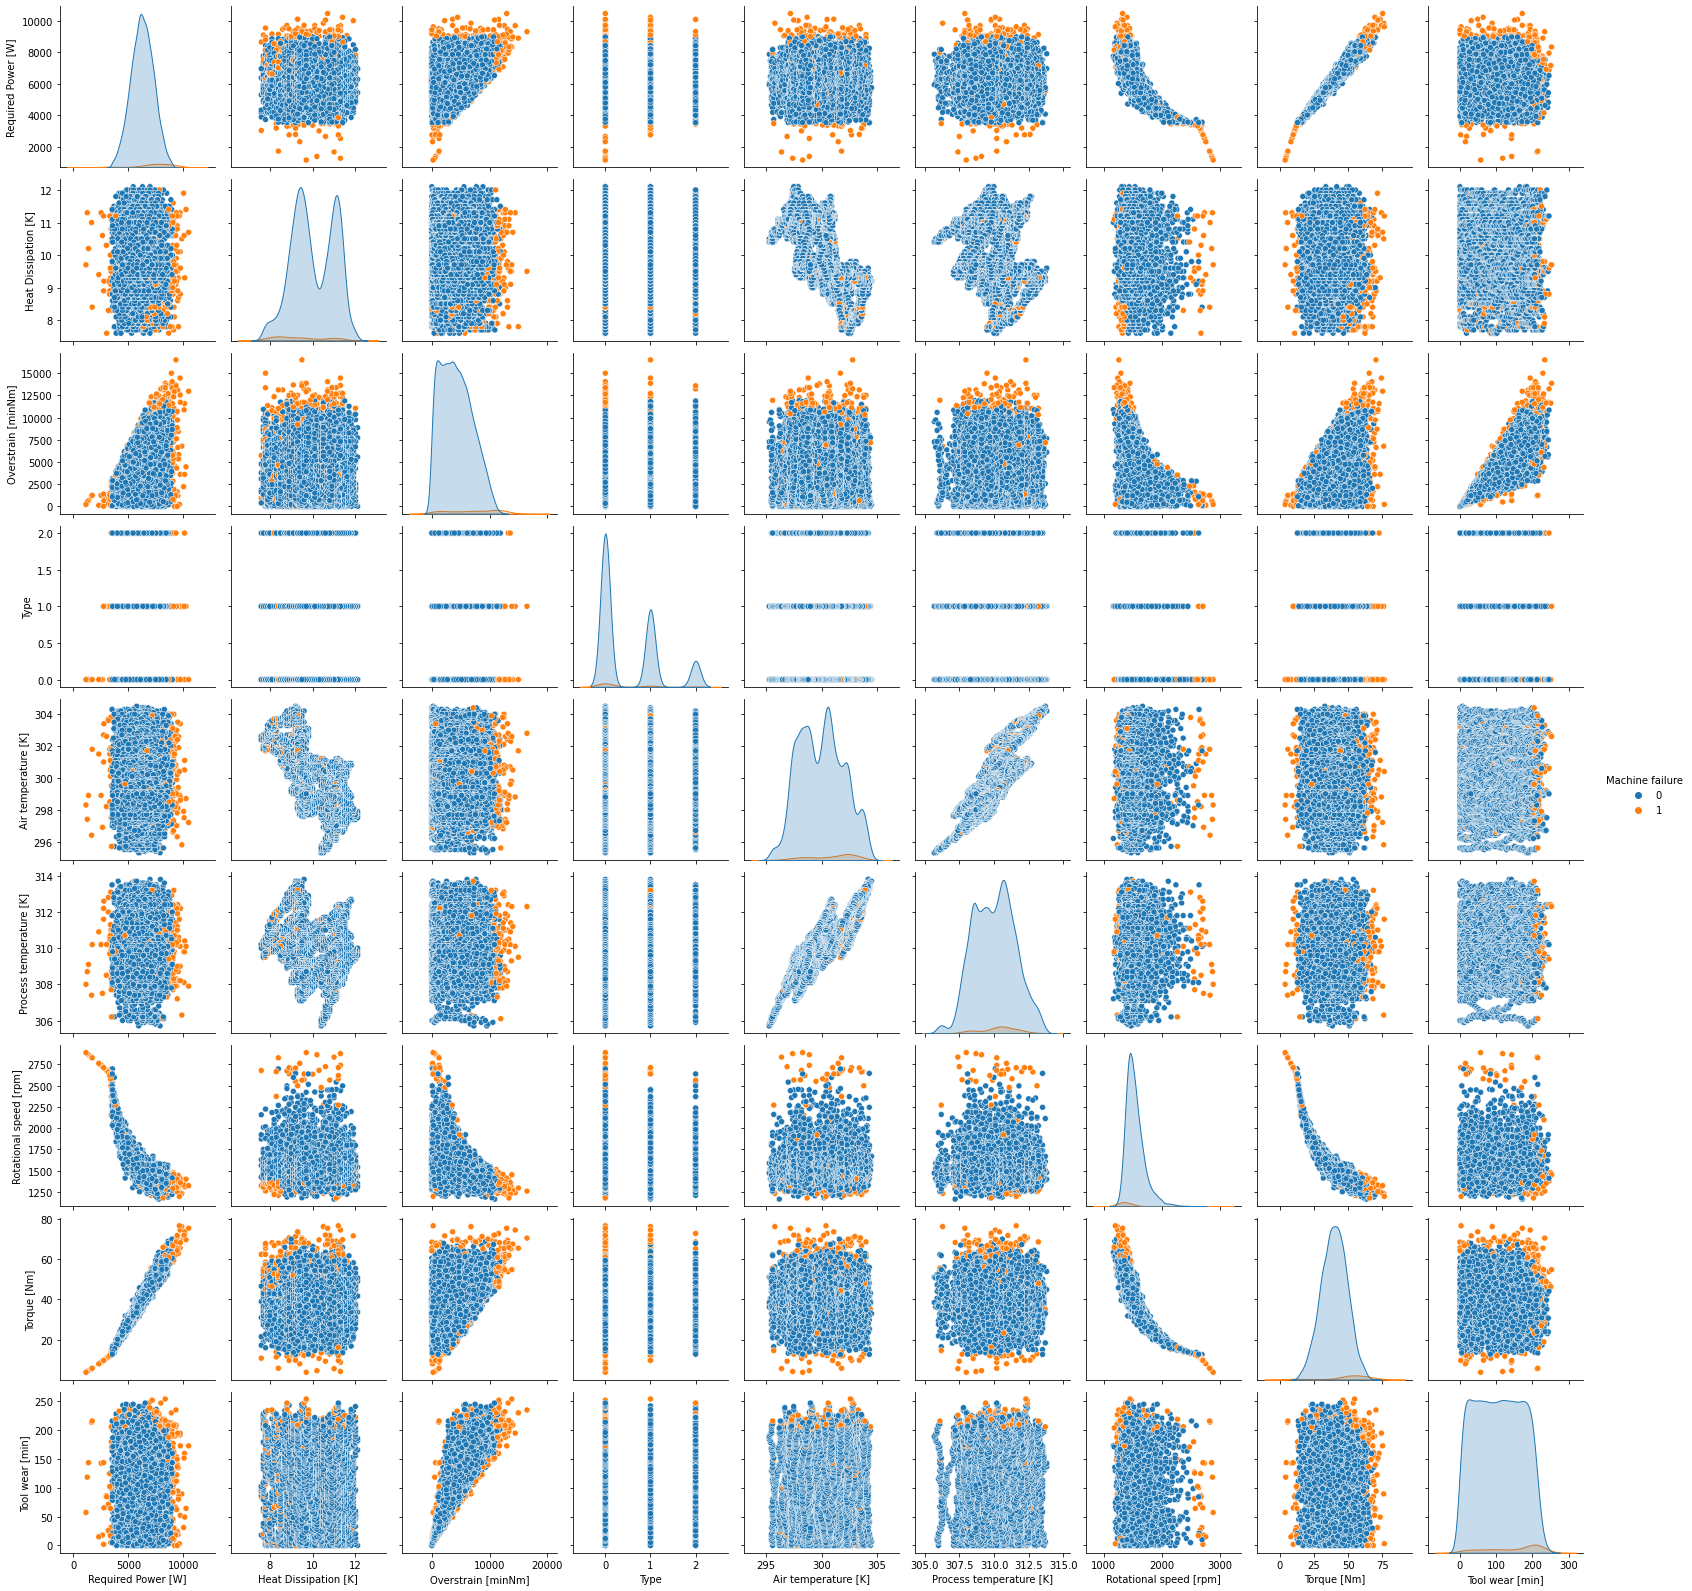

In [7]:
sns.pairplot(data, hue="Machine failure")